In [4]:
import pandas as pd 
import requests as r 
import matplotlib.pyplot as plt 
import numpy as np
import os
from io import BytesIO
plt.style.use('ggplot')

In [ ]:
# Короче работает стремновато, но иногда постреливает.
# Нужно побольше разобрать \ потюнить и мб что то выйдет

In [5]:
def query(q,url='http://85.193.83.20:8123',format=True,**kwargs):
    if format:
        return pd.read_csv(BytesIO(r.post(url=url,
                data=(q+'\nFORMAT CSVWithNames').encode('utf-8'),
                auth= (os.getenv('CRYPTO_ETL_USER'),os.getenv('CRYPTO_ETL_PASSWORD'))
                ).content),**kwargs)
    
    else:
        return r.post(url=url,
                data=q.encode('utf-8'),
                auth=(os.getenv('CRYPTO_ETL_USER'),os.getenv('CRYPTO_ETL_PASSWORD')))
    

In [6]:
qq = query('''
select toStartOfInterval(toDateTime(trade_time/1000), interval 1 minute) as t, 
count(trade_id)  trades_count,
avg(price)  as avg_price
from crypto.binancews_trade
where t>'2022-01-21'
group by t
order by t

''').astype({'t':'datetime64[ms]'})

In [7]:
def rsi_calc(df,w=14):
    wsa = (100 - 100 / df.pct_change().where(lambda x: x>0).rolling(w,1).mean().div(df.pct_change().where(lambda x: x<0).rolling(w,1).mean().abs()).add(1))
    rsi = wsa.shift(-1).mul(w-1).add(wsa).div(w)
    return rsi

In [201]:
def rsi_check(w=14,rsi_thr = 20,**kwargs):
    fig,ax = plt.subplots(2,1,sharex=True,**kwargs)
    idx = np.random.randint(0,qq.shape[0]-300)

    price = qq.set_index('t').iloc[idx:idx+300]['avg_price']
    rsi = rsi_calc(qq.set_index('t')['avg_price'],w=w).iloc[idx:idx+300]

    rsi_idx_min = rsi.where(lambda x: x<rsi_thr ).dropna().index
    rsi_idx_max = rsi.where(lambda x: x>100-rsi_thr ).dropna().index

    price.plot(ax=ax[0],linestyle='--',color='b',ylabel='price')
    rsi.plot(ax=ax[1],ylim=[0,100],color='b',xlabel='datetime',ylabel='rsi')
    ax[1].axhspan(30,70,alpha=0.1,color='green')

    lines_underbuy = [ax[0].axvline(i,linestyle=':',color='green') for i in rsi_idx_min if i!=None]
    lines_overbuy = [ax[0].axvline(i,linestyle=':',color='red') for i in rsi_idx_max if i!=None]

    lines_underbuy.append(0)
    lines_overbuy.append(0)
    
    ax[0].legend([lines_underbuy[0],lines_overbuy[0]],['stock_underbuy','stock_overbuy'])
    plt.suptitle('RSI price KPI')

C:\Users\CHARUB~1\AppData\Local\Temp/ipykernel_9148/1226049163.py:21: UserWarning: Legend does not support 0 instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  ax[0].legend([lines_underbuy[0],lines_overbuy[0]],['stock_underbuy','stock_overbuy'])


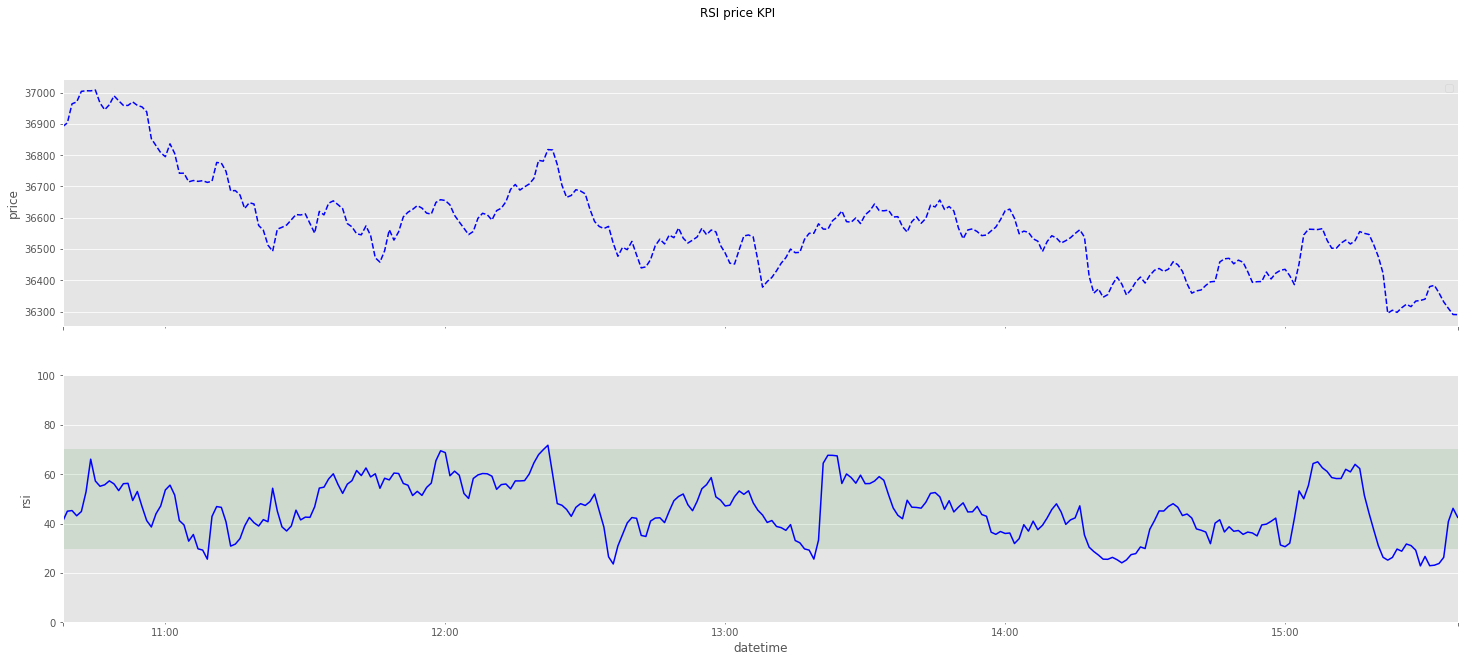

In [207]:
rsi_check(figsize=(25,10))

In [198]:
def divergense_check(resample='10min',**kwargs):
    fig,ax = plt.subplots(2,1,sharex=True,**kwargs)
    idx = np.random.randint(0,qq.shape[0]-300)

    price = qq.set_index('t').iloc[idx:idx+300]['avg_price']
    rsi = rsi_calc(qq.set_index('t')['avg_price']).iloc[idx:idx+300]

    price_max = price.resample(resample,label='right').last().diff() >0
    rsi_max = rsi.resample(resample,label='right').last().diff() >0
    
    idx_div = price_max.loc[(price_max != rsi_max).values].where(lambda x: x==True).dropna().index
    idx_conv = price_max.loc[(price_max != rsi_max).values].where(lambda x: x!=True).dropna().index

    price.plot(ax=ax[0],color='b',ylabel='price')
    rsi.plot(ax=ax[1],color='b',ylim=[0,100],ylabel='RSI',xlabel='datetime')

    ax[0].scatter(idx_conv,price.resample(resample,label='right').last().loc[idx_conv],color='green')
    ax[0].scatter(idx_conv-pd.Timedelta(resample),price.resample(resample,label='right').last().loc[idx_conv-pd.Timedelta(resample)],color='green')

    ax[0].scatter(idx_div,price.resample(resample,label='right').last().loc[idx_div],color='red',marker='*')
    ax[0].scatter(idx_div-pd.Timedelta(resample),price.resample(resample,label='right').last().loc[idx_div-pd.Timedelta(resample)],color='red',marker='*')

    lines_buy = [ax[0].axvspan(i-pd.Timedelta(resample),i,linestyle=':',color='green',alpha=0.1) for i in idx_conv]
    lines_sell = [ax[0].axvspan(i-pd.Timedelta(resample),i,linestyle=':',color='red',alpha=0.1) for i in idx_div]
    lines_buy = [ax[1].axvspan(i-pd.Timedelta(resample),i,linestyle=':',color='green',alpha=0.1) for i in idx_conv]
    lines_sell = [ax[1].axvspan(i-pd.Timedelta(resample),i,linestyle=':',color='red',alpha=0.1) for i in idx_div]


    ax[0].legend([lines_sell[0],lines_buy[0]],['divergence_sell','divergence_buy'])

    plt.suptitle('Divergence price KPI')

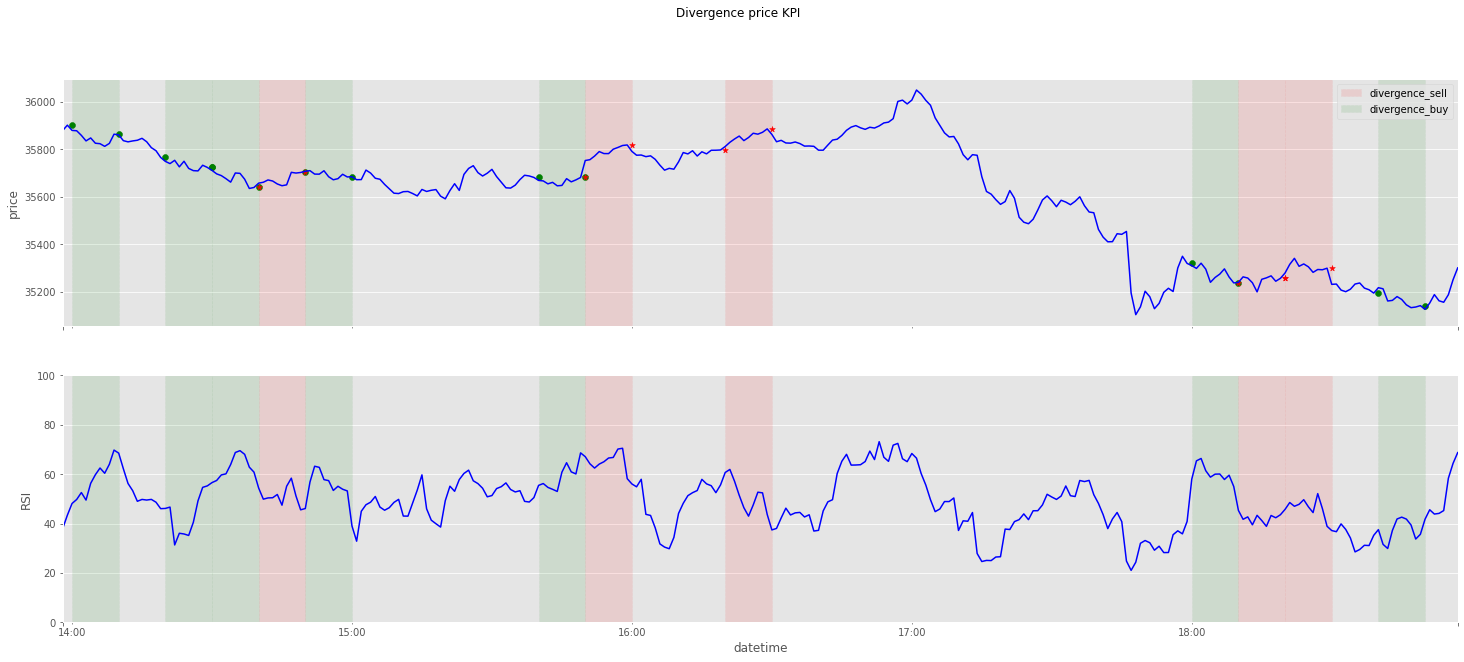

In [199]:
divergense_check(resample = '10min',figsize=(25,10))